In [144]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
from sklearn.inspection import DecisionBoundaryDisplay


# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


In [145]:
input_size = 2
output_size = 1

# Activation functions and their derivatives
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

# Neural Network class definition
class TwoLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        """Initializes weights and biases."""
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((output_size, 1))
        self.learning_rate = learning_rate

    def forward(self, X):
        """Performs the forward pass."""
        X = X.T  # Transpose X to shape (input_size, n_samples)
        self.A1 = self.W1 @ X + self.b1  # (hidden_size, n_samples)
        self.Z1 = relu(self.A1)          # (hidden_size, n_samples)
        self.A2 = self.W2 @ self.Z1 + self.b2  # (output_size, n_samples)
        self.Z2 = sigmoid(self.A2)       # (output_size, n_samples)
        return self.Z2.T  # Transpose back to shape (n_samples, output_size)

    def compute_loss(self, y_true, y_pred):
        """Computes cross-entropy loss."""
        m = y_true.shape[0]
        y_true = y_true.reshape(-1, 1)  # Shape (n_samples, 1)
        loss = -np.sum(
            y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8)
        ) / m
        return loss

    def backward(self, X, y_true):
        """Performs the backward pass and updates weights and biases."""
        m = y_true.shape[0]
        X = X.T  # Shape (input_size, n_samples)
        y_true = y_true.reshape(1, m)  # Shape (1, n_samples)

        # Output layer error
        dA2 = self.Z2 - y_true  # Shape (output_size, n_samples)

        # Gradients for W2 and b2
        dW2 = (1 / m) * dA2 @ self.Z1.T  # (output_size, hidden_size)
        db2 = (1 / m) * np.sum(dA2, axis=1, keepdims=True)  # (output_size, 1)

        # Hidden layer error
        dZ1 = self.W2.T @ dA2  # (hidden_size, n_samples)
        dA1 = dZ1 * relu_derivative(self.A1)  # (hidden_size, n_samples)

        # Gradients for W1 and b1
        dW1 = (1 / m) * dA1 @ X.T  # (hidden_size, input_size)
        db1 = (1 / m) * np.sum(dA1, axis=1, keepdims=True)  # (hidden_size, 1)

        # Update weights and biases
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def batchSGD(self, X, y, epochs, batch_size):
        """Trains the neural network using mini-batch SGD."""
        history = []
        for epoch in range(epochs):
            # Shuffle the data at the beginning of each epoch
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            # Mini-batch training
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                # Forward and backward pass
                self.forward(X_batch)
                self.backward(X_batch, y_batch)
            # Compute loss for monitoring
            y_pred_all = self.forward(X)
            loss_all = self.compute_loss(y, y_pred_all)
            history.append(loss_all)
        return history

    def predict(self, X):
        """Predicts class labels for samples in X."""
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)# Cross-validation function


In [146]:
def cross_validation(hidden_size, learning_rate, epochs, batch_size):
    kf = KFold(n_splits=5, shuffle=True, random_state=3)
    cv_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        # Initialize a new model for each fold
        model_cv = TwoLayerPerceptron(input_size, hidden_size, output_size, learning_rate)
        model_cv.batchSGD(X_train_fold, y_train_fold, epochs, batch_size)
        y_val_pred = model_cv.predict(X_val_fold)
        score = accuracy_score(y_val_fold, y_val_pred)
        cv_scores.append(score)
    return cv_scores

# Hyperparameter grids
hidden_sizes = [2, 4, 8, 16]
learning_rates = [0.01, 0.1, 0.5]
batch_sizes = [8, 16, 32]
epochs_list = [50, 100]

results = []

# Grid search with cross-validation
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for epochs in epochs_list:
                cv_scores = cross_validation(hidden_size, learning_rate, epochs, batch_size)
                mean_cv_score = np.mean(cv_scores)
                results.append({
                    "hidden_size": hidden_size,
                    "learning_rate": learning_rate,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    "cv_scores": cv_scores,
                    "mean_cv_score": mean_cv_score
                })
# Create a DataFrame to display results
df_results = pd.DataFrame(results)
print("\nCross-Validation Results:")
print(tabulate(df_results, headers='keys', tablefmt='pretty', showindex=False))

# Select the best hyperparameters based on the highest mean CV score
best_params = df_results.loc[df_results['mean_cv_score'].idxmax()]
print("\nBest Hyperparameters:")
print(best_params)

# Train final model with best hyperparameters
best_hidden_size = int(best_params['hidden_size'])
best_learning_rate = best_params['learning_rate']
best_batch_size = int(best_params['batch_size'])
best_epochs = int(best_params['epochs'])






Cross-Validation Results:
+-------------+---------------+------------+--------+-----------------------------------------------+--------------------+
| hidden_size | learning_rate | batch_size | epochs |                   cv_scores                   |   mean_cv_score    |
+-------------+---------------+------------+--------+-----------------------------------------------+--------------------+
|      2      |     0.01      |     8      |   50   |   [0.6875, 0.5875, 0.69375, 0.725, 0.59375]   |       0.6575       |
|      2      |     0.01      |     8      |  100   |  [0.6125, 0.725, 0.75625, 0.74375, 0.73125]   | 0.7137499999999999 |
|      2      |     0.01      |     16     |   50   |  [0.59375, 0.60625, 0.6125, 0.65625, 0.725]   |      0.63875       |
|      2      |     0.01      |     16     |  100   |  [0.675, 0.69375, 0.61875, 0.66875, 0.7625]   | 0.6837500000000001 |
|      2      |     0.01      |     32     |   50   |  [0.55625, 0.65625, 0.61875, 0.73125, 0.675]  |       0.64

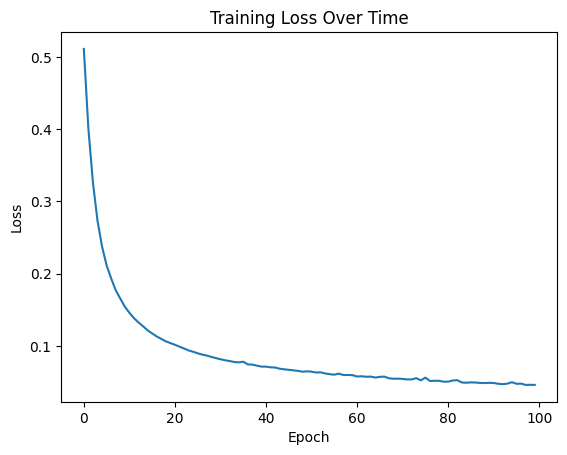


Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       387
           1       1.00      0.99      0.99       413

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       103

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [147]:
model = TwoLayerPerceptron(input_size=2, hidden_size=best_hidden_size,
                           output_size=1, learning_rate=best_learning_rate)

# Train the model on the entire training set
history = model.batchSGD(X_train, y_train, best_epochs, best_batch_size)

# Plot training loss over epochs
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

# Evaluate on training data
y_train_pred = model.predict(X_train)
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

# Evaluate on test data
y_test_pred = model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))



In [ ]:
The code explores hyperparameters for a two-layer neural network using cross-validation. It tests hidden layer sizes [2, 4, 8, 16], learning rates [0.01, 0.1, 0.5], batch sizes [8, 16, 32], and epochs [50, 100]. The best hyperparameters are selected based on the highest mean cross-validation accuracy. These include the optimal hidden layer size 8, learning rate 0.1, batch size 16, and number of epochs 100, which are then used to train and evaluate the final model. The model performs well on the test set, indicating effective learning and generalization.